In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution
from functools import reduce

Tic-Tac-Toe is a fairly easy to implement game. It's also fairly easy to play, which makes it a lot simpler to set up an AI capable of making valid(not necessarily good) plays.

Here's the code for the game itself:

In [2]:
class TTTGame:
    def __init__(self, size, players):
        self.size = size
        self.board = np.zeros((self.size, self.size))
        self.curPlayer = -1
        self.players = players
        for i in range(len(self.players)):
            #Each player keeps their own internal copy of the board that
            #gets updated each turn by the game instance
            self.players[i].board = self.board
        
    def isValidMove(self, coords):
        if self.board[coords] == 0:
            return True
        else:
            return False
        
    def play(self):
        curPlayerIdx = (self.curPlayer + 1) // 2
        self.players[curPlayerIdx].board = self.board
        
        coords = self.players[curPlayerIdx].play()
        if self.isValidMove(coords):
            self.board[coords] = self.curPlayer
            self.curPlayer *= -1
            return 1
        return 0
    
    #This is ugly, I know
    #Returns the number corresponding to a player if he's the winner,
    #zero if there's no winner yet, or two if there's neither a winner
    #nor free slots to play in, ie. a tie(it can't tell in advance)
    def checkWinner(self):
        for i in self.board.sum(axis=0):
            if int(np.abs(i) // self.size) != 0:
                return int(i//self.size)
        for i in self.board.sum(axis=1):
            if int(np.abs(i) // self.size) != 0:
                return int(i//self.size)
        i = self.board.trace()
        if int(np.abs(i) // self.size) != 0:
            return int(i/self.size)
        i = self.board[::-1].trace()
        if int(np.abs(i) // self.size) != 0:
            return int(i/self.size)
        if self.board[self.board == 0].size == 0:
            return 2
        return 0
    
    def printBoard(self):
        boardStr = [*map(lambda row:
            [*map(lambda elem:
                ({-1: "O ", 0: "_ ", 1:"X "})[elem]
            , row)]
        , self.board)]
        boardStr = reduce(lambda row, res:
            "".join(res) + "\n" + "".join(row)
        , boardStr, "")
        print(boardStr)
        
    def reset(self):
        self.__init__(self.size, self.players)

And an AI that simply chooses valid moves at random:

In [3]:
class RandomPlayer:
    def __init__(self):
        self.board = np.array([])
        
    def play(self):
        empty = np.where(self.board == 0)
        randn = np.random.randint(0, empty[0].size)
        coords = tuple([empty[0][randn], empty[1][randn]])
        return coords

And finally a single hidden layer neural network player:

In [4]:
class NNPlayer:
    #This rather curious default sigmoid is actually tailored for backprop(cf. Lecun, 1998)
    #will it work well in this differential evolution-backed problem? No idea.
    def __init__(self, nNeurons, sigmoid=lambda x: 1.7159 * np.tanh(2/3 * x)):
        self.board = np.array([])
        self.nNeurons = nNeurons
        self.sigmoid = sigmoid

    def initNN(self):
        self.nInputs = self.board.size
        self.hiddenLayerWeights = np.random.normal(size=(self.nNeurons,self.nInputs))
        self.hiddenLayerBias = np.random.normal(size=(self.nNeurons, 1))
        self.outputLayerWeights = np.random.normal(size=(1, self.nNeurons))

    #I set this up rather haphazard. A little more thought into the dimensions of
    #the matrices involved would probably result in cleaner code with less transposes
    def runNN(self, nNInput):
        return np.dot(self.outputLayerWeights, 
                      self.sigmoid(np.dot(self.hiddenLayerWeights, nNInput) 
                                   + self.hiddenLayerBias))[0,0]
    
    #Instead of using 2D coordinates as inputs/outputs I flatten the board into an
    #1D array both for simplicity and memory usage concerns.
    def evalBoard(self):
        ravelBoard = self.board.flatten()
        emptyBoard = np.where(ravelBoard == 0)[0]
        scores = []
        for i in emptyBoard:
            ravelBoard[i] = -1
            scores.append(self.runNN(ravelBoard))
            ravelBoard[i] = 0
        scores = np.array(scores)
        max_idx = emptyBoard[np.where(scores == scores.max())[0][0]]
        res =  np.unravel_index(max_idx, self.board.shape)
        return res

    def play(self):
        return self.evalBoard()
    
    def exportWeightVector(self):
        return np.hstack((self.hiddenLayerWeights.ravel(), 
                          self.hiddenLayerBias.ravel(), 
                          self.outputLayerWeights.ravel()))
    
    def importWeightVector(self, weights):
        #I should really do this based on the actual layer dimensions 
        #independently of the layers already being set-up or not
        cuts = np.cumsum([self.hiddenLayerWeights.size, \
                          self.hiddenLayerBias.size, \
                          self.outputLayerWeights.size])
        self.hiddenLayerWeights = weights[0:cuts[0]].reshape(self.hiddenLayerWeights.shape)
        self.hiddenLayerBias = weights[cuts[0]:cuts[1]].reshape(self.hiddenLayerBias.shape)
        self.outputLayerWeights = weights[cuts[1] :].reshape(self.outputLayerWeights.shape)

This helper function clashes two players a certain number of times and keeps track of winrates.

It takes a number of games to run and a game instance(NN players must be properly initialized beforehand) as arguments.

In [5]:
def nGames(Ngames, game):
    wincount = []

    for i in range(Ngames):
        #print("Game {}".format(i))
        #game.printBoard()
        while True:
            game.play()
            #game.printBoard()
            if(game.checkWinner() != 0):
                break
        wincount.append(game.checkWinner())
        game.reset()
        
    return np.array(wincount)

This trainer class trains a neural network with scipy's differential evolution implementation, using score in games against a random player as the cost function. It works, but I think it's possible to do better.

In [6]:
class NNDETrainer:
    def __init__(self, size, nNeurons, initialWeights=None):
        self.size = size
        self.nNplayer = NNPlayer(nNeurons)
        self.game = TTTGame(size, (self.nNplayer, RandomPlayer()))
        self.nNplayer.initNN()
        if initialWeights is not None:
            self.nNplayer.importWeightVector(initialWeights)

    #The cost function here is a weighed average of the results of many
    #games against a random player
    def cost(self, weights):
        self.nNplayer.importWeightVector(weights)

        N = 25
        wincount = nGames(N, game)
        wincount[wincount == 2] = 0
        count = wincount.sum() / N
        return -count

    def trainDE(self):
        bounds = np.array([(-1e6, 1e6)] * (self.nNplayer.hiddenLayerWeights.size 
                                       + self.nNplayer.hiddenLayerBias.size 
                                       + self.nNplayer.outputLayerWeights.size))
        trainResults = differential_evolution(self.cost, bounds, tol = 0.5)
        print(trainResults.message)
        
        if trainResults.success == True:
            print(trainResults.nit)
            print(trainResults.nfev)
            return trainResults.x
            
        else:
            print("Optimization failed somewhere")

With everything set up let's see how the AI fares against a random player:

In [7]:
N = 5000
nNeurons = 3
nNPlayer = NNPlayer(nNeurons, lambda x: np.fmax(0, x))
players = (nNPlayer, RandomPlayer())
game = TTTGame(nNeurons, players)
nNPlayer.initNN()
#nNPlayer.importWeightVector(np.fromfile("trainedvec.csv"))

In [8]:
wincount = nGames(N, game)
labels, count = np.unique(wincount, return_counts=True)

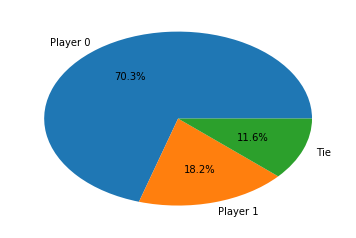

In [9]:
labels = [*map(lambda x: {-1:"Player 0", 1:"Player 1", 2:"Tie"}[x], labels)]
count = count / N
plt.pie(count, labels=labels, autopct='%.1f%%')
plt.show()

It probably did anywhere from not bad to abysmal right now. Let's train it for a while and see if it does better.

In [10]:
trainer = NNDETrainer(game.size, nNeurons, nNPlayer.exportWeightVector())
res = trainer.trainDE()

Optimization terminated successfully.
1
1704


In [11]:
nNPlayer.importWeightVector(res)

wincount= nGames(N, game)
labels, count = np.unique(wincount, return_counts=True)

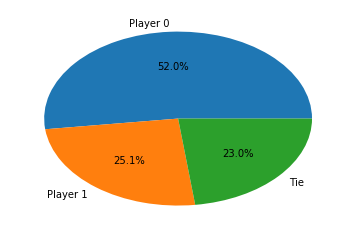

In [12]:
labels = [*map(lambda x: {-1:"Player 0", 1:"Player 1", 2:"Tie"}[x], labels)]
count = count / N
plt.pie(count, labels=labels, autopct='%.1f%%')
plt.show()

This almost always better, but considering tic-tac-toe is a solved game, that's an awful lot of computation for little gain. Bummer!

In [13]:
#trained_vec = np.hstack((nnp.hiddenLayerWeights.ravel(), nnp.hiddenLayerBias.ravel(), nnp.outputLayerWeights.ravel()))

#trained_vec.tofile("trainedvec.csv")